In [2]:
import torch
import transformers
model_name_or_path = 'checkpoints/tinyllama_caption2instruct_ft'
model = transformers.LlamaForCausalLM.from_pretrained(
        model_name_or_path,
        attn_implementation='flash_attention_2',
        torch_dtype=torch.bfloat16,
    ).cuda()
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name_or_path)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
from instruct_tri2tri.tinyllama_ft.conversation import conv_llama_2
conv = conv_llama_2.copy()
roles = conv_llama_2.roles
inp = '3D rendering of a white sofa with wooden legs and frame.'
conv.append_message(conv_llama_2.roles[0], inp)
conv.append_message(conv_llama_2.roles[1], None)
prompt = conv.get_prompt()
inputs = tokenizer(prompt, return_tensors='pt')
for key, value in inputs.items():
    inputs[key] = value.cuda()

In [2]:
import json

j = json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_550k.json'))

In [3]:
j[0]

{'id': '53d0b31aa7f84bc4b1733224963d0114',
 'image': 'objaverse/Cap3D_imgs_view0/53d0b31aa7f84bc4b1733224963d0114',
 'conversations': [{'from': 'human',
   'value': '<triplane>\nDescribe the 3D model concisely.'},
  {'from': 'gpt',
   'value': '3D rendering of a white sofa with wooden legs and frame.'}]}

In [18]:
output = model.generate(**inputs)
# tokenizer.decode(output[0], special_tokens=True)

In [24]:
tokenizer.decode(output[0, inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

'make the sofa a brown leather sofa'

In [5]:
import json 
json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k_0_4.json'))

[{'image': 'objaverse/Cap3D_imgs_view0/53d0b31aa7f84bc4b1733224963d0114',
  'caption': '3D rendering of a white sofa with wooden legs and frame.',
  'instruct': 'make the sofa a leather sofa'},
 {'image': 'objaverse/Cap3D_imgs_view0/25f25e35aada40e49194657fd51c1199',
  'caption': '3D model of a wooden fence with posts and gate, featuring a sand base.',
  'instruct': 'make the fence made of metal'},
 {'image': 'objaverse/Cap3D_imgs_view0/9ff331513cea44a2938d09a03d7b0493',
  'caption': 'White plastic cylinder resembling a toilet paper holder.',
  'instruct': 'make it a toilet paper holder made of gold'},
 {'image': 'objaverse/Cap3D_imgs_view0/f78e38ccea1d45dcaefe1970e7df4035',
  'caption': '3D model of a forklift truck with a trailer.',
  'instruct': 'make the truck a tank'},
 {'image': 'objaverse/Cap3D_imgs_view0/112c059282cf4511a01fd27211edcae8',
  'caption': 'A 3D model of a wooden table and bench.',
  'instruct': 'make it a wooden table and bench made of marble'},
 {'image': 'objaver

In [1]:
from instruct_tri2tri.tsr.system import TSR, InstructTri2Tri
model = InstructTri2Tri.from_pretrained(
    'instruct_tri2tri/tsr/instruct_tri2tri_config',
    config_name="config.yaml",
    weight_name="model.ckpt",
)

/home/shangyu/Cyberpunk8T/anaconda_space/envs/langsplat/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
import numpy as np
from PIL import Image
image = Image.fromarray(np.zeros((512, 512, 3), dtype=np.uint8))

In [3]:
import torch
with torch.no_grad():
    tokens = model([image], 'turn it to red', 'cpu')
    tokens.shape

In [4]:
tokens.shape

torch.Size([3, 40, 4096])

In [4]:
scene_codes = model([image], 'turn it to red', 'cuda', T)
scene_codes.shape

torch.Size([1, 1024, 3072])

In [11]:
import os
import json

data0 = json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k_0_4.json'))
data1 = json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k_1_4.json'))
data2 = json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k_2_4.json'))
data3 = json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k_3_4.json'))

In [12]:
data = data0 + data1 + data2 + data3
len(data)

493857

In [14]:
data[0]

{'image': 'objaverse/Cap3D_imgs_view0/53d0b31aa7f84bc4b1733224963d0114',
 'caption': '3D rendering of a white sofa with wooden legs and frame.',
 'instruct': 'make the sofa a leather sofa'}

In [13]:
with open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k.json', 'w') as f:
    json.dump(data, f)

In [15]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import rembg
from instruct_tri2tri.tsr.utils import remove_background, resize_foreground

save_path = 'data/objaverse/images'
img_names = os.listdir('data/objaverse/Cap3D_imgs_view0')
os.makedirs(save_path, exist_ok=True)
rembg_session = rembg.new_session()
for img_name in tqdm(img_names):
    image = Image.open(os.path.join('data/objaverse/Cap3D_imgs_view0', img_name))
    image = remove_background(image, rembg_session)
    image = resize_foreground(image, 0.85)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
    image = Image.fromarray((image * 255.0).astype(np.uint8))
    image.save(f'{save_path}/{img_name}.jpg')

  0%|          | 41/661577 [00:15<69:07:46,  2.66it/s] 


KeyboardInterrupt: 

In [1]:
from instruct_tri2tri.tsr.system import InstructTri2Tri

model = InstructTri2Tri.from_pretrained(
    'instruct_tri2tri/tsr/instruct_tri2tri_config',
    'config.yaml',
    'model.ckpt'
)

/home/shangyu/Cyberpunk8T/anaconda_space/envs/langsplat/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
import numpy as np
from PIL import Image

image0 = Image.fromarray(np.zeros((512, 512, 3), dtype=np.uint8))
image1 = Image.fromarray(np.zeros((512, 512, 3), dtype=np.uint8))

In [11]:
token0 = model.forward_tsr([image0], 'cpu')
token0.shape

torch.Size([1, 3, 40, 64, 64])

In [12]:
token1 = model([image1], 'make it green', 'cpu')
token1.shape

torch.Size([1, 3, 40, 64, 64])

In [13]:
b, n, c, h, w = token0.shape
token0 = token0.permute(0, 3, 4, 1, 2).reshape(b*h*w, n*c)
token1 = token1.permute(0, 3, 4, 1, 2).reshape(b*h*w, n*c)

In [16]:
token0.shape

torch.Size([4096, 120])

In [20]:
def custom_mse(pred, target):
    return ((target-pred)**2).sum(-1).mean()

In [22]:
import torch
custom_mse(token0, token1)

tensor(122.6055, grad_fn=<MeanBackward0>)

In [1]:
import json
from tqdm import tqdm
datas = json.load(open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k_bak.json'))

In [2]:
len(datas)

493857

In [3]:
datas[0]

{'image': 'objaverse/Cap3D_imgs_view0/53d0b31aa7f84bc4b1733224963d0114',
 'caption': '3D rendering of a white sofa with wooden legs and frame.',
 'instruct': 'make the sofa a leather sofa'}

In [4]:
target_json = []
for data in tqdm(datas):
    tmp_dict = {}
    image = data['image']
    image = image.replace('Cap3D_imgs_view0', 'images')
    image += '.jpg'
    instruct_image = image.replace('images', 'instruct_images')
    tmp_dict['image'] = image
    tmp_dict['instruct_image'] = instruct_image
    tmp_dict['caption'] = data['caption']
    tmp_dict['instruct'] = data['instruct']
    target_json.append(tmp_dict)


  0%|          | 0/493857 [00:00<?, ?it/s]

100%|██████████| 493857/493857 [00:00<00:00, 714991.34it/s]


In [5]:
target_json[0]

{'image': 'objaverse/images/53d0b31aa7f84bc4b1733224963d0114.jpg',
 'instruct_image': 'objaverse/instruct_images/53d0b31aa7f84bc4b1733224963d0114.jpg',
 'caption': '3D rendering of a white sofa with wooden legs and frame.',
 'instruct': 'make the sofa a leather sofa'}

In [6]:
with open('data/objaverse/cap3d_automated_objaverse_highquality_instruct_550k.json', 'w') as f:
    json.dump(target_json, f)

In [1]:
import os
len(os.listdir('data/objaverse/instruct_images'))

493857

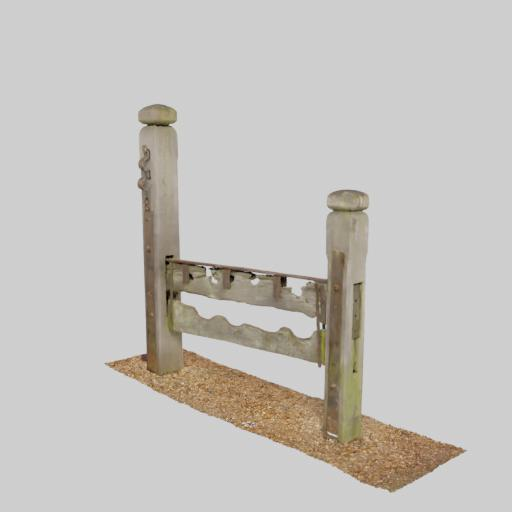

In [12]:
from PIL import Image
Image.open('data/objaverse/Cap3D_imgs_view0/25f25e35aada40e49194657fd51c1199')

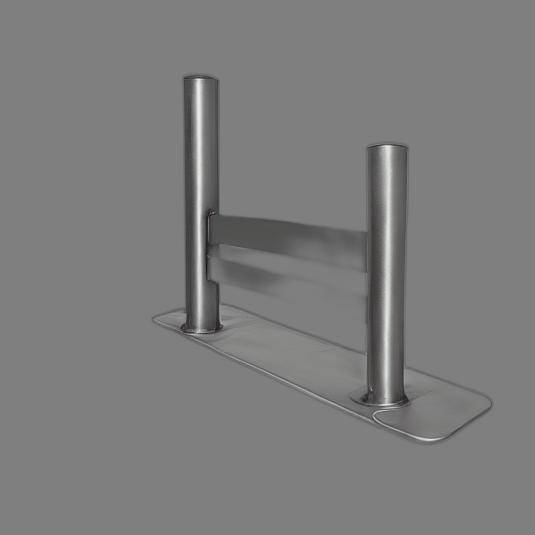

In [13]:
Image.open('data/objaverse/instruct_images/25f25e35aada40e49194657fd51c1199.jpg')

In [11]:
import torch
from diffusers import EulerAncestralDiscreteScheduler, AutoencoderKL
from instruct_tri2tri.tsr.pipeline_stable_diffusion_instruct_pix2pix import StableDiffusionInstructPix2PixPipeline
model_id = "ckpts/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
vae = AutoencoderKL.from_pretrained(model_id, subfolder='vae', torch_dtype=torch.float16)
vae.requires_grad_(False)
pipe.to("cuda:0")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

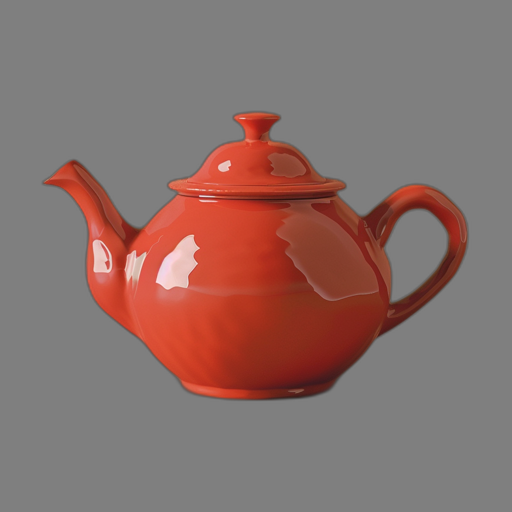

In [12]:
from PIL import Image
image = Image.open('examples/teapot.png').resize((512, 512))
image

In [13]:
prompt = "add some pattern to the teapot"
out = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1)
# images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
out.latents.shape

torch.Size([1, 4, 64, 64])

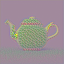

In [15]:
import numpy as np
latent_image = out.latents
latent_image_norm = (latent_image - latent_image.min()) / (latent_image.max() - latent_image.min())
latent_image_pil = Image.fromarray((latent_image_norm[0].permute(1, 2, 0)[..., :3] * 255).cpu().detach().numpy().astype(np.uint8))
latent_image_pil

In [16]:
pipe.vae.config.scaling_factor

0.18215

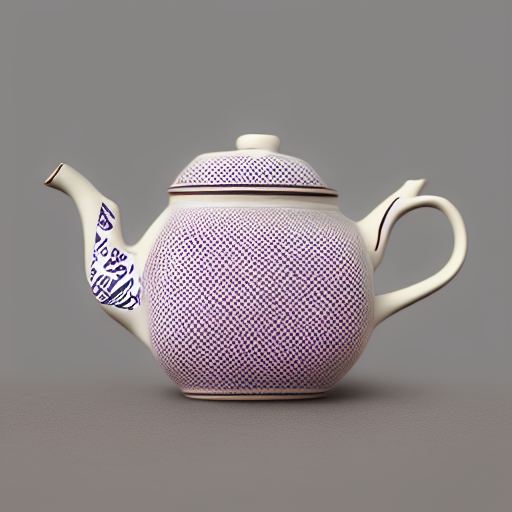

In [17]:
out.images[0]

In [18]:
from torchvision import transforms as T
import numpy as np
from PIL import Image
def preprocess(images):
    if type(images) == list:
        images_pt = []
        for image in images:
            images_pt.append(T.ToTensor()(image) * 2 - 1)
        return torch.stack(images_pt)
    else:
        return T.ToTensor()(images).unsqueeze(0) * 2 - 1

def postprocess(latent_image, pil=True):
    latent_image = (latent_image + 1) / 2
    if pil:
        latent_image = latent_image[0].permute(1, 2, 0)
        return Image.fromarray((latent_image * 255).cpu().detach().numpy().astype(np.uint8))

In [20]:
vae = vae.to('cuda:0')
image_pt = preprocess([out.images[0]])
encode_out = vae.encode(image_pt.to(device=vae.device, dtype=vae.dtype))
latent_image_ = encode_out.latent_dist.mode()

In [21]:
latent_image_ == latent_image

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

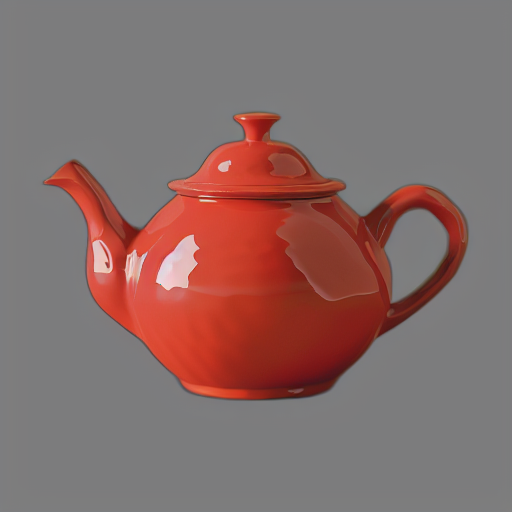

In [22]:
with torch.no_grad():
    decode_out = vae.decode(encode_out.latent_dist.mode(), return_dict=False)[0]
    re_img = postprocess(decode_out)
re_img

In [12]:
image1 = pipe('add some pattern to the teapot', image=image, num_inference_steps=10, image_guidance_scale=2).images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

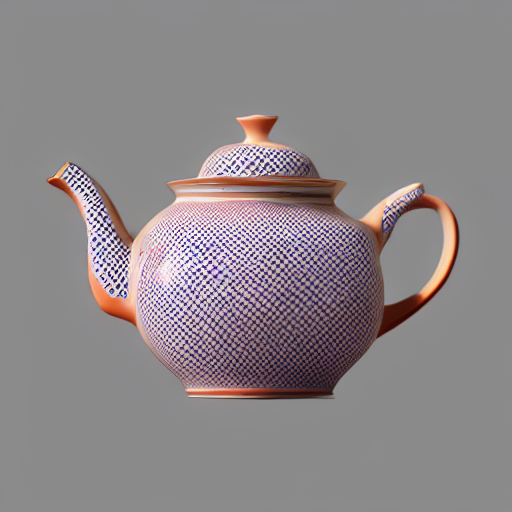

In [13]:
image1

In [11]:
image1.size

(872, 872)

In [14]:
image1.save('1.jpg')

In [3]:
image2 = image.resize((512, 512))

In [4]:
image_pt = pipe.image_processor.preprocess(image2)

print(image_pt.shape)
# 5. Prepare Image latents
# image_latents = pipe.prepare_image_latents(
#     image
# )

torch.Size([1, 3, 512, 512])


In [7]:
with torch.no_grad():
    encode_out = pipe.vae.encode(image_pt.half().to('cuda:2'))

In [12]:
encode_out.latent_dist.mode().shape

torch.Size([1, 4, 64, 64])

In [15]:
with torch.no_grad():
    encode_out = pipe.vae.encode(image_pt.half().to('cuda:2'))
with torch.no_grad():
    decode_out = pipe.vae.decode(encode_out.latent_dist.mode(), return_dict=False)[0]

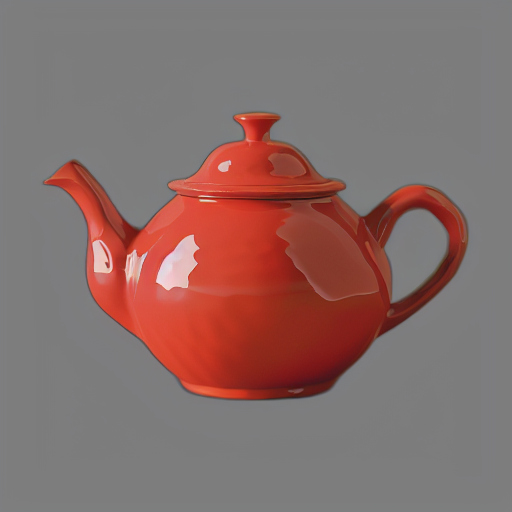

In [19]:
pipe.image_processor.postprocess(decode_out)[0]

In [7]:
from instruct_tri2tri.tinyllama_ft.train.finetune import read_jsonl

datas = read_jsonl('data/objaverse/gpt-generated-prompts.jsonl')

loading from data/objaverse/gpt-generated-prompts.jsonl, there are 452148 samples


In [8]:
len(datas)

452148

In [9]:
datas[0]

{'input': '"Dreama Tolle Perry » Artist and Writer » ""Tuscany Outside My Door"""',
 'edit': 'Move the Tuscany to a different location',
 'output': '"Dreama Tolle Perry » Artist and Writer » ""Tuscany in Alaska Outside My Door"""',
 'url': 'https://i.pinimg.com/236x/d4/7d/4a/d47d4a43aeedae07fdac54f72e28cc71--flower-paintings-art-paintings.jpg'}

In [10]:
import json
from tqdm import tqdm

target_json = []
for data in tqdm(datas):
    tmp = {}
    conversations = []
    conversations.append({'from': 'human', 'value': data['input']})
    conversations.append({'from': 'gpt', 'value': data['edit']})
    tmp['conversations'] = conversations
    target_json.append(tmp)

100%|██████████| 452148/452148 [00:02<00:00, 164854.35it/s]


In [12]:
with open('data/objaverse/gpt-generated-prompts-450k.json', 'w') as f:
    json.dump(target_json, f)

In [3]:
data[0]

{'input': '"Dreama Tolle Perry » Artist and Writer » ""Tuscany Outside My Door"""',
 'edit': 'Move the Tuscany to a different location',
 'output': '"Dreama Tolle Perry » Artist and Writer » ""Tuscany in Alaska Outside My Door"""',
 'url': 'https://i.pinimg.com/236x/d4/7d/4a/d47d4a43aeedae07fdac54f72e28cc71--flower-paintings-art-paintings.jpg'}

In [5]:
from PIL import Image
import torch
from instruct_tri2tri.tsr.utils import (
    BaseModule,
    ImagePreprocessor,
    find_class,
    get_spherical_cameras,
    scale_tensor,
)
image_preprocessor = ImagePreprocessor()
image = Image.open('1.jpg').resize((512, 512))
latent_image_tokenizer_cls = "tsr.models.tokenizers.latentimage.DINOLatentImageTokenizer"
latent_image_tokenizer = {}
latent_image_tokenizer = find_class(latent_image_tokenizer_cls)(latent_image_tokenizer)

In [2]:
image_preprocessor([image], 512).permute(0, 3, 1, 2).shape

torch.Size([1, 3, 512, 512])

In [6]:
import numpy as np
def postprocess(latent_image, pil=True):
    latent_image = (latent_image + 1) / 2
    if pil:
        latent_image = latent_image[0].permute(1, 2, 0)
        return Image.fromarray((latent_image * 255).cpu().detach().numpy().astype(np.uint8))

In [7]:
with torch.no_grad():
    encode_out = latent_image_tokenizer.vae.encode(image_preprocessor([image], 512).permute(0, 3, 1, 2) * 2 - 1)
    decode_out = latent_image_tokenizer.vae.decode(encode_out.latent_dist.mode(), return_dict=False)[0]
    re_image = postprocess(decode_out)

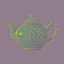

In [8]:
latent_image = encode_out.latent_dist.mode()
latent_image_norm = (latent_image - latent_image.min()) / (latent_image.max() - latent_image.min())
latent_image_pil = Image.fromarray((latent_image_norm[0].permute(1, 2, 0)[..., :3] * 255).cpu().detach().numpy().astype(np.uint8))
latent_image_pil

In [15]:
latent_image[0, :, 0, 4]

tensor([ 4.2211, -3.0097,  3.0023,  0.5920])

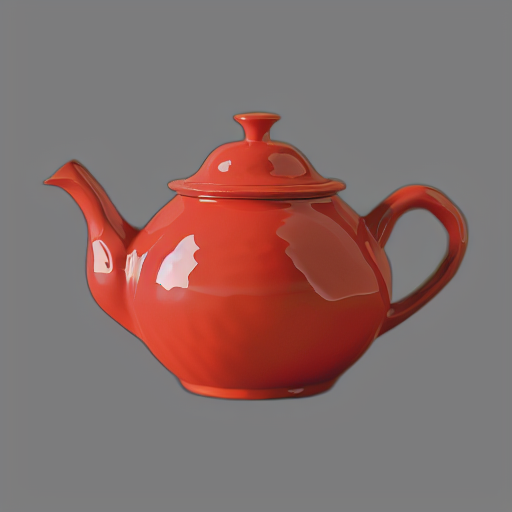

In [19]:
re_image

In [6]:
import torch

out = latent_image_tokenizer(torch.randn((1, 3, 512, 512)))

In [7]:
out.shape

torch.Size([1, 768, 1025])

In [8]:
from instruct_tri2tri.tsr.system import TSR
model = TSR.from_pretrained(
    'stabilityai/TripoSR',
    config_name="config.yaml",
    weight_name="model.ckpt",
)

In [21]:
model.image_tokenizer(torch.randn((1, 3, 512, 512))).shape

torch.Size([1, 768, 1025])